This nb trains and evaluates a dnn model using the genre list as input.

- [ ] normalize encoding to be between 0 and 1?
- [ ] use Bayes parameter search
- [ ] cyclic learning rates?

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

seed = 23

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras 
from tensorflow.keras import Input, layers
tf.keras.backend.clear_session() # for easy reset of notebook state

import numpy as np
np.random.random_seed = 23
import pandas as pd

from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
from IPython import display
import pydot
from graphviz import Digraph
from matplotlib import pyplot as plt
from IPython import display

import genre_data_loader, genre_upperbound

Import the data

In [2]:
# get currrent date for latest version of data set
%store -r now

X_path_train = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now)
y_path_train = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now)
X_path_test = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_test_{}.csv'.format(now)
y_path_test = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_test_{}.csv'.format(now)

# call data loader script for training data
genre_data = genre_data_loader.LoadGenreData(now, X_path_train = X_path_train, y_path_train = y_path_train,
                                                  X_path_test = X_path_test, y_path_test = y_path_test)
# call it for train data
genre_data_train = genre_data_loader.LoadGenreData(now, X_path_train = X_path_train, y_path_train = y_path_train)
# call it for test data
genre_data_test = genre_data_loader.LoadGenreData(now, X_path_train = X_path_test, y_path_train = y_path_test)

# load data with genre sets
data_train = genre_data_train.as_lists()

#data_balanced = genre_data_train.get_balanced_sample()

data_test = genre_data_test.as_lists()

data = genre_data.as_lists()

# create list of all genres
list_of_genres = genre_data.get_list_of_genres()

# Create a dictionary of {genre : genre_id}
dict_gid = genre_data.get_dict_genre_to_id()
dict_idg = genre_data.get_dict_id_to_genre()

In [3]:
#Size of the vocab:
vocab_size = len(dict_gid)

In [4]:
data_train.head()

genrelist_length gender  \
artist                                   
Pablo_Holman                  3   male   
Bobby_Edwards                 1   male   
La_Palabra                    4   male   
Sherrick                      2   male   
Allen_Collins                 1   male   

                                                      genre_list  
artist                                                            
Pablo_Holman                                [pop, emo_pop, rock]  
Bobby_Edwards                                          [country]  
La_Palabra     [son_montuno, afro_cuban_jazz, guaracha, salsa...  
Sherrick                                         [soul, r_and_b]  
Allen_Collins                                    [southern_rock]

In [5]:
def encode_labels_in_columns(df, dict_gid, max_list_length):
    # encode labels as ints within the list
    def encode_list(row):
        return [dict_gid[item] for item in row.genre_list]

    df['genres_encoded_as_list'] = df.apply(encode_list, axis = 1)

    #Check that the encoding is consistent: 
    # n = np.random.randint(data.shape[0])
    # [label_id_dict[item] for item in data.genrelist.iloc[n]], data.genres_encoded_as_list.iloc[n]

    #Encode into new columns

    #create columns with zeros
    for i in range(max_list_length):
        df['label_{}'.format(i)] = np.zeros((df.shape[0]), dtype = 'int64')

    def encode_columns(row):
        for i, id in enumerate(row.genres_encoded_as_list):
            row.loc['label_{}'.format(i)] = id
        return row

    df = df.apply(encode_columns, axis = 1)

    # Encode targets. The categories still appear as strings. To see the encoding use df.column.cat.codes.
    df['gender'] = df.gender.apply(lambda x: 1 if x == 'female' else 0)
    
    df.drop(['genrelist_length', 'genre_list', 'genres_encoded_as_list'], axis =1, inplace = True)
    
    return df

In [6]:
max_list_length = 73

In [7]:
data_train_processed = encode_labels_in_columns(data_train, dict_gid, max_list_length)

In [8]:
data_train_processed.head()

gender  label_0  label_1  label_2  label_3  label_4  label_5  \
artist                                                                        
Pablo_Holman        0     1041      467     1164        0        0        0   
Bobby_Edwards       0      335        0        0        0        0        0   
La_Palabra          0     1253       32      622     1196        0        0   
Sherrick            0     1258     1130        0        0        0        0   
Allen_Collins       0     1276        0        0        0        0        0   

               label_6  label_7  label_8  ...  label_63  label_64  label_65  \
artist                                    ...                                 
Pablo_Holman         0        0        0  ...         0         0         0   
Bobby_Edwards        0        0        0  ...         0         0         0   
La_Palabra           0        0        0  ...         0         0         0   
Sherrick             0        0        0  ...         0         0         0   
Allen_Collins        0        0        0  ...         0         0         0   

               label_66  label_67  label_68  label_69  label_70  label_71  \
artist                                                                      
Pablo_Holman          0         0         0         0         0         0   
Bobby_Edwards         0         0         0         0         0         0   
La_Palabra            0         0         0         0         0         0   
Sherrick              0         0         0         0         0         0   
Allen_Collins         0         0         0         0         0         0   

               label_72  
artist                   
Pablo_Holman          0  
Bobby_Edwards         0  
La_Palabra            0  
Sherrick              0  
Allen_Collins         0  

[5 rows x 74 columns]

Now split into X,y DFs

In [9]:
y_train = data_train_processed.pop('gender')
X_train = data_train_processed.copy()

Baseline:

In [10]:
print(f'{round(100*(1-y.sum()/y.shape[0]),1)}% of artists are male.') 

NameError: name 'y' is not defined

## Define Models

In [14]:
# list only as input
# GAP seems to work better than GMP; Flatten may also be competetive

lr = .001 # .0002-.0003 seem good

def create_model():
    loss_fcn = keras.losses.BinaryCrossentropy(from_logits=True)
    
    
    opt = tf.keras.optimizers.Adam(learning_rate = lr)
    
    # the list input; use vocab_size+1 since 0 is saved to indicate no label
    list_input = layers.Input(shape = (max_list_length,), name = 'list_input')
    embed = layers.Embedding(input_dim = vocab_size+1, output_dim = 256, input_length = max_list_length, name = 'list_embed')(list_input)
    # pool layer
    fop = layers.GlobalAveragePooling1D()(embed)
    # add dense layers
    k = 64
    
    # resize from fop layer
    y = layers.Dense(k, activation = None)(fop)
    z = layers.Dense(k, activation = 'sigmoid')(fop)
    x = layers.Dense(k, activation = 'relu')(fop)
    
    x = layers.Dense(k, activation = 'relu')(x)
    x = layers.Dropout(.4)(x)
    x = layers.Multiply()([x,z])
    x = layers.Dropout(.4)(x)
    # reshape pool layer to add to Dense
    x = layers.Add()([x,y]) # requires output of embedding and of last dense are equal
    x = layers.Dense(k, activation = 'relu')(x)
    x = layers.Dropout(.4)(x)
    x = layers.Multiply()([x,z]) # requires output of embedding and of last dense are equal
    x = layers.Dense(k, activation = 'relu')(x) 
    x = layers.Dropout(.4)(x)
    pred = layers.Dense(1, name = 'predictions')(x)

    model = keras.Model(inputs = [list_input], outputs = [pred])
    
    model.compile(loss=loss_fcn,
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

### Train Model

In [17]:
X = X_train.values
y = y_train.values

# X_1_train = X_values[:,1:74]
# y_train = np.asarray(y_values)

model = create_model()

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto',
#     min_delta=0.01, cooldown=0, min_lr=0
#     )

# clr = tfa.optimizers.CyclicalLearningRate(
#     initial_learning_rate = .0001,
#     maximal_learning_rate = .001,
#     step_size = 4000,
#     scale_fn = lambda x: 1.,
#     name = 'clr'
# )

# callbacks = [clr]

history = model.fit({'list_input':X_train},
                    {'predictions':y_train},
                    batch_size=32,
                    epochs=10,
                    validation_split = .2,
                    #callbacks = callbacks,
                    verbose = 2
                    )

Epoch 1/10
310/310 - 2s - loss: 0.6104 - accuracy: 0.6901 - val_loss: 0.5604 - val_accuracy: 0.6858
Epoch 2/10
310/310 - 2s - loss: 0.5295 - accuracy: 0.7066 - val_loss: 0.5492 - val_accuracy: 0.7052
Epoch 3/10
310/310 - 2s - loss: 0.5096 - accuracy: 0.7171 - val_loss: 0.5317 - val_accuracy: 0.7023
Epoch 4/10
310/310 - 2s - loss: 0.4968 - accuracy: 0.7193 - val_loss: 0.5496 - val_accuracy: 0.7076
Epoch 5/10
310/310 - 2s - loss: 0.4928 - accuracy: 0.7262 - val_loss: 0.5284 - val_accuracy: 0.7213
Epoch 6/10
310/310 - 2s - loss: 0.4834 - accuracy: 0.7330 - val_loss: 0.5531 - val_accuracy: 0.7193
Epoch 7/10
310/310 - 2s - loss: 0.4857 - accuracy: 0.7312 - val_loss: 0.5647 - val_accuracy: 0.7015
Epoch 8/10
310/310 - 2s - loss: 0.4789 - accuracy: 0.7382 - val_loss: 0.5307 - val_accuracy: 0.7044
Epoch 9/10
310/310 - 2s - loss: 0.4761 - accuracy: 0.7341 - val_loss: 0.5367 - val_accuracy: 0.7217
Epoch 10/10
310/310 - 2s - loss: 0.4685 - accuracy: 0.7424 - val_loss: 0.5326 - val_accuracy: 0.7209

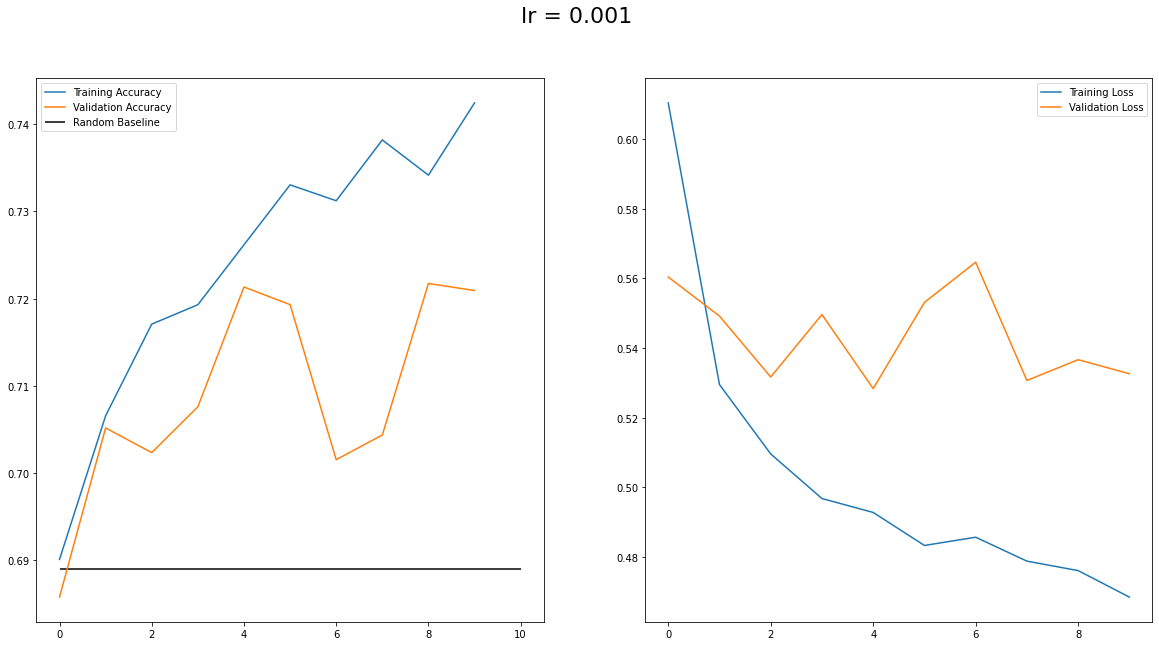

In [18]:
fig, axs = plt.subplots(1,2, figsize = (20,10))

fig.suptitle(f'lr = {lr}', fontsize = 22)
axs[0].plot(history.history['accuracy'], label = 'Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label = 'Validation Accuracy')

axs[1].plot(history.history['loss'], label = 'Training Loss')
axs[1].plot(history.history['val_loss'], label = 'Validation Loss')

axs[0].hlines(0.689,0,len(history.history['accuracy']), label = 'Random Baseline')
#plt.ylim(0,.1)
axs[0].legend()
axs[1].legend()

plt.show()
#print(min(history.history['accuracy']))

Train with cross validation:

In [92]:
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

cvscores_acc = []

X_values = X.values
y_values = y.values

for train, test in kf.split(X_values,y_values):
    
    X_0_train = X_values[train,0:1]
    X_1_train = X_values[train,1:74]
    y_train = np.asarray(y_values[train])
    
    #print(X_0_train.shape, X_1_train.shape, y_train.shape)
    
    model = create_model()
    
#     dataset_length_train = tf.data.Dataset.from_tensor_slices((X_0_train, y_train)) 
#     dataset_list_train = tf.data.Dataset.from_tensor_slices((X_1_train, y_train)) 
    
    history = model.fit({'list_input':X_1_train, 'length_input':X_0_train},
                    {'predictions':y_train},
                    batch_size=16,
                    epochs=33,
                    verbose = 0 
                    )
    
    
    X_0_test = X_values[test,0:1]
    X_1_test = X_values[test,1:73]
    y_test = y_values[test]
    
#     dataset_length_test = tf.data.Dataset.from_tensor_slices((X_0_test, y_test)) 
#     dataset_list_test = tf.data.Dataset.from_tensor_slices((X_1_test, y_test)) 
    
    scores = model.evaluate(
                    {'list_input':X_1_train, 'length_input':X_0_train},
                    {'predictions':y_train},
                    verbose = 0)
    
    print(f'Accuracy = {scores[1]}.')
    cvscores_acc.append(scores[1])
    

print(f'Mean Accuracy is {np.mean(cvscores_acc):.4f} and STD of Accuracy is {np.std(cvscores_acc):.4f}')

Accuracy = 0.6874663233757019.


KeyboardInterrupt: 

Ignore for now: Another possibility: Create TF Dataset using the corpus from gensim as a generator: Another possibility: Create TF Dataset using the corpus from gensim as a generator:

In [ ]:
def corpus_gen():
    for i in len(corpus):
        yield (i, corpus[i])

In [ ]:
dataset = tf.data.Dataset.from_generator(
    corpus_gen,
    (tf.int64, --tensor_one_hot--)
)